In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
fracs_count = 3  # количество трещин
K_c = 1e6  # Па*м^(1/2) трещиностойкость

In [3]:
Q_0, p_0 = symbols('Q0 p0', real=True)  # суммарный расход на забое и забойное давление

Q = np.array(symbols(f'Q1:{fracs_count+1}', real=True))  # расходы на каждой из трещин
x_f = np.array(symbols(f'x_f1:{fracs_count+1}', real=True))  # полудлина каждой из трещин
E = np.array(symbols(f'E1:{fracs_count+1}', real=True))  # модуль плоской деформации каждой из трещин
h = np.array(symbols(f'h1:{fracs_count+1}', real=True))  # мощность продуктивной зоны каждой из трещин
K, n, phi = symbols('K n phi', real=True)  # реологические параметры жидкости и геометрический параметр трещины

n_p = np.array(symbols(f'n_p1:{fracs_count+1}', real=True))  # количество перфораций на каждой из трещин
d_p = np.array(symbols(f'd_p1:{fracs_count+1}', real=True))  # диаметр перфораций на каждой из трещин
C_d = np.array(symbols(f'C_d1:{fracs_count+1}', real=True))  # коэффициент эррозии на каждой из трещин
rho_s = symbols('rho_s', real=True)  # средняя плотность смеси

R = np.array(symbols(f'R1:{fracs_count+1}', real=True))  # радиус участков трубы к каждой из трещин
L = np.array(symbols(f'L1:{fracs_count+1}', real=True))  # длина участков трубы, ведущих к каждой из трещин
K = symbols('K', real=True)

u_m = np.array(symbols(f'u_m1:{fracs_count+1}', real=True))  # средняя скорость на рассматриваемом участке к каждой из трещин
sigma_min = symbols(f'sigma_min1:{fracs_count+1}')  # давление закрытия для каждой из трещин

In [4]:
def p_net():
    V = h * (2 * x_f) * K_c * (S.Pi*h)**(1/2) / E
    a = (((n + 3) * (2 * n + 1)**n * K * E**(2*n+2)) / \
         (S.Pi * 2**(2 * n) * n**n * phi**n * h**(3 * n + 3))) ** (1 / (2 * n + 3))
    p_net = a * Q**(n/(2*n+3)) * V**(1/(2*n+3))  # давление на каждой из трещин
    return p_net

def delta_p_perf():
    # падение давления на перфорациях на каждой из трещин
    delta_p_perf = 8 * rho_s / (S.Pi**2 * C_d**2 * n_p**2 * d_p**4) * Q * abs(Q)
    return delta_p_perf

def delta_p_fric():
    for i, u in enumerate(u_m):
        u_m[i] = (Q_0 - sum([Q[j] for j in range(i)])) / (S.Pi * R[i]**2)
    delta_p_fric = 8 * (K / R) * (u_m / R) * L # падение давления на трение в трубе для каждой из трещин
    return delta_p_fric

In [5]:
def kirchhoff_solver(parameter_values):
    all_eqns = np.array([])  # массив со всеми уравнениями законов Кирхгофа
    
    # добавляем левую часть уравнений второго закона Кирхгофа в массив all_eqns
    for i in range(fracs_count):
        all_eqns = np.append(all_eqns, p_0 - sigma_min[i] - p_net()[i] - delta_p_perf()[i] - sum([delta_p_fric()[j] for j in range(i+1)]))

    # добавляем левую часть уравнения первого закона Кирхгофа в массив all_eqns
    all_eqns = np.append(all_eqns, Q_0 - sum(Q))
    
    # матрица Якоби
    J = np.zeros(shape=(fracs_count+1, fracs_count+1), dtype=object)
    for i, _ in enumerate(all_eqns):
        for j, _ in enumerate(Q):
            J[i, j] = diff(all_eqns[i], Q[j])
        J[i, -1] = diff(all_eqns[i], p_0)
    J_sym = Matrix(J)

    # начальные приближения числовых значений неизвестных параметров задачи
    solution_values = {}
    for i in range(fracs_count):
        solution_values[Q[i]] = N(Q_0.subs(parameter_values)/fracs_count)  # расходы на каждой из трещин (начальное приближение)
    solution_values[p_0] = N(sigma_min[0].subs(parameter_values))  # забойное давление (начальное приближение)

    # вектор решения
    solution_vector = np.array(list(N(Matrix(Q).subs(solution_values)))+[N(p_0.subs(solution_values))], dtype='float64').reshape(fracs_count+1,1)
    # предыдущий вектор решения
    last_solution_vector = solution_vector - 100

    # реализация метода Ньютона
    while np.linalg.norm(solution_vector - last_solution_vector) > 1e-4:
        # обновляем предыдущий вектор решения
        last_solution_vector = solution_vector.copy()
        # матрица Якоби
        J = np.array(N(J_sym.subs({**parameter_values, **solution_values})), dtype='float64')
        # вектор остатков
        residual_vector = np.array(N(Matrix(all_eqns).subs({**parameter_values, **solution_values})), dtype='float64')
        # новый вектор решения
        solution_vector -= np.matmul(np.linalg.inv(J), residual_vector)
        # обновление значений текущего вектора решения в словаре solution_values
        for i in range(fracs_count):
            solution_values[Q[i]] = solution_vector.reshape(fracs_count+1,)[i]
        solution_values[p_0] = solution_vector.reshape(fracs_count+1,)[-1]
    return solution_values

In [6]:
parameter_values = {
    Q_0: 800 / 86400,  # расход на забое, м^3/с
    K: 0.001,  # первый реологический параметр жидкости (вязкость воды), Па*с
    n: 1,  # второй реологический параметр жидкости (ньютоновская жидкость - вода)
    phi: 0.3,  # безразмерный геометрический параметр трещины
    rho_s: 1000  # плотность жидкости (воды), кг/м^3
}

for i in range(fracs_count):
    parameter_values[x_f[i]] = 50 # полудлина трещины, м
    parameter_values[E[i]] = 1e10  # модули плоской деформации трещин, Па
    parameter_values[h[i]] = 2  # мощности продуктивной зоны, м
    parameter_values[n_p[i]] = 16  # количества перфораций
    parameter_values[d_p[i]] = 0.02  # диаметры перфораций, м
    parameter_values[C_d[i]] = 0.7  # безразмерные коэффициенты эррозии
    parameter_values[R[i]] = 0.08  # радиусы участков трубы между i-ой и (i-1)-ой трещинами, м
    parameter_values[L[i]] = 100  # длины участков трубы между i-ой и (i-1)-ой трещинами, м
    parameter_values[sigma_min[i]] = 1e7  # давления закрытия трещин, Па

In [7]:
solution_values = kirchhoff_solver(parameter_values)
print(solution_values.get(p_0))

12384160.091854366


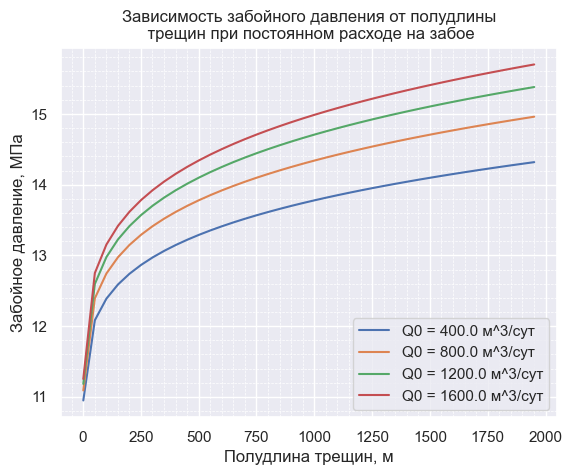

In [8]:
for water_rate in np.array([400, 800, 1200, 1600]) / 86400:
    parameter_values[Q_0] = water_rate
    x_f_values = [i for i in range(1, 2000, 50)]
    p_0_values = []
    for x_f_value in x_f_values:
        for i in range(fracs_count):
            parameter_values[x_f[i]] = x_f_value
        solution_values = kirchhoff_solver(parameter_values)
        p_0_values.append(solution_values.get(p_0))
    plt.plot(x_f_values, np.array(p_0_values)/1e6, label=f'Q0 = {water_rate*86400} м^3/сут')
plt.xlabel('Полудлина трещин, м')
plt.ylabel('Забойное давление, МПа')
plt.title('Зависимость забойного давления от полудлины\n трещин при постоянном расходе на забое')
plt.minorticks_on()
plt.grid(which='minor', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

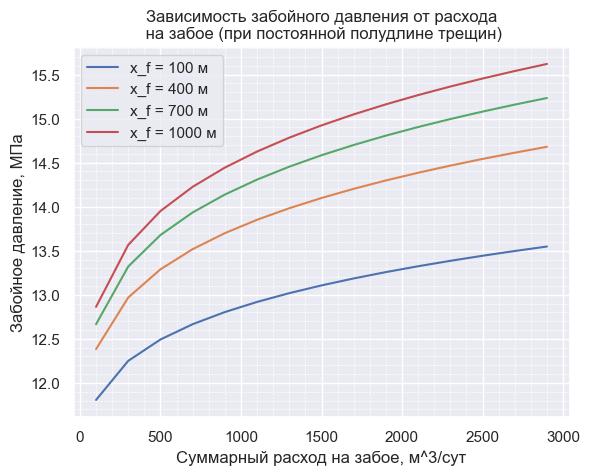

In [9]:
parameter_values[Q_0] = 800 / 86400
for i in range(fracs_count):
    parameter_values[x_f[i]] = 50 # полудлина трещины, м

for x_f_value in np.array([100, 400, 700, 1000]):
    for i in range(fracs_count):
        parameter_values[x_f[i]] = x_f_value

    water_rate_values = np.array(range(100, 3100, 200))
    p0_values = []

    for water_rate in water_rate_values / 86400:
        parameter_values[Q_0] = water_rate
        solution_values = kirchhoff_solver(parameter_values)
        p0_values.append(solution_values.get(p_0))

    plt.plot(water_rate_values, np.array(p0_values)/1e6, label=f'x_f = {x_f_value} м')
plt.xlabel('Суммарный расход на забое, м^3/сут')
plt.ylabel('Забойное давление, МПа')
plt.title('Зависимость забойного давления от расхода\n на забое (при постоянной полудлине трещин)')
plt.minorticks_on()
plt.grid(which='minor', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [10]:
#x_f = 